# Analysis & Plot the correlation among different rutting parameters for asphalt binder

This notebook includes the codes for analysis and plotting on the results of High-Temperature Performance Grade (HTPG), Multiple Stress Creep Recovery (MSCR), and Frequency Sweep tests on different recovered and tank binders used in the PTF lanes. This notebook aimed to evaluate the correlation among these parameters. 

Author: Farhad Abdollahi (farhad.abdollahi.ctr@dot.gov) 

Date: 06/30/2025

___

In [2]:
# Importing the required libraries. 
import os
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [3]:
# Read the results. 
HTPG = pickle.load(open('./Data/ProcessedData_HTPG.pkl', 'rb'))
MSCR = pickle.load(open('./Data/ProcessedData_MSCR.pkl', 'rb'))
FS   = pickle.load(open('./Data/ProcessedData_FS.pkl', 'rb'))
OutputDir = '../_Figures'

In [4]:
# Combine the HTPG and MSCR into one DataFrame. 
Data = pd.merge(HTPG[['Lane', 'Field_Aging', 'RepNum', 'HTPG']], 
                MSCR[['Lane', 'Field_Aging', 'RepNum', 'Lab_Aging', 'R0.1', 'R3.2', 'Rdiff', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff']], 
                on=['Lane', 'Field_Aging', 'RepNum'])
Data.head()

,Lane,Field_Aging,RepNum,HTPG,Lab_Aging,R0.1,R3.2,Rdiff,Jnr0.1,Jnr3.2,Jnrdiff
0,1,0-Month,1,81.7,NaN,42.96,36.71,14.548417,0.1889,0.2111,11.752250
1,1,0-Month,2,81.9,NaN,42.96,36.73,14.501862,0.1869,0.2088,11.717496
2,1,0-Month,3,83.0,NaN,43.04,36.72,14.684015,0.1886,0.2114,12.089077
3,2,0-Month,1,79.8,NaN,42.22,34.44,18.427286,0.2432,0.2797,15.008224
4,2,0-Month,2,80.0,NaN,42.46,34.52,18.699953,0.2480,0.2864,15.483871


In [5]:
# Convert the FS into Dataframe. 
df = {'Lane': [], 'Field_Aging': [], 'RepNum': []}
df.update({f'ZSV_{temp}C': [] for temp in [10, 22, 34, 46, 58, 70, 82]})
df.update({f'Shenoy_{temp}C': [] for temp in [10, 22, 34, 46, 58, 70, 82]})
for lane in FS.keys():
    ln = int(lane[1:])
    Field_Aging = '0-Month'         # We only have the Frequency Sweep for the recovered binders.
    for rep in range(1, 4):         # Read all three replicates. 
        df['Lane'].append(ln)
        df['Field_Aging'].append(Field_Aging)
        df['RepNum'].append(rep)
        for i, temp in enumerate(FS[lane]['ZSV'][f'Rep{rep}']['Temperatures_°C']):
            ZSV    = FS[lane]['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][i]
            Shenoy = FS[lane]['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][i]
            df[f'ZSV_{temp}C'].append(ZSV)
            df[f'Shenoy_{temp}C'].append(Shenoy)
df = pd.DataFrame(df)
df.head()

,Lane,Field_Aging,RepNum,ZSV_10C,ZSV_22C,ZSV_34C,ZSV_46C,ZSV_58C,ZSV_70C,ZSV_82C,Shenoy_10C,Shenoy_22C,Shenoy_34C,Shenoy_46C,Shenoy_58C,Shenoy_70C,Shenoy_82C
0,1,0-Month,1,1.435130e+08,1.332581e+07,1.394886e+06,174076.843749,19738.181433,2265.574786,345.343556,1.000000e-10,1.000000e-10,7.460705e+03,4.841184e+02,70.921667,13.134771,2.854869
1,1,0-Month,2,NaN,NaN,NaN,NaN,18804.624596,2312.643998,361.197677,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,72.288633,13.709454,2.999805
2,1,0-Month,3,NaN,NaN,NaN,NaN,18378.529603,2268.931756,354.825031,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,71.366906,13.478457,2.895336
3,2,0-Month,1,9.325387e+07,8.768031e+06,9.673941e+05,126168.699381,15497.423598,1859.189133,302.024156,1.000000e-10,1.000000e-10,4.217630e+03,3.454423e+02,54.763573,10.733010,2.423965
4,2,0-Month,2,NaN,NaN,NaN,NaN,17249.145734,2174.503626,345.442566,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,65.760278,12.629995,2.791937


In [6]:
# Merge the results into "Data" dataframe. 
Data = pd.merge(Data, df, on=['Lane', 'Field_Aging', 'RepNum'])
Data.head()

,Lane,Field_Aging,RepNum,HTPG,Lab_Aging,R0.1,R3.2,Rdiff,Jnr0.1,Jnr3.2,...,ZSV_58C,ZSV_70C,ZSV_82C,Shenoy_10C,Shenoy_22C,Shenoy_34C,Shenoy_46C,Shenoy_58C,Shenoy_70C,Shenoy_82C
0,1,0-Month,1,81.7,NaN,42.96,36.71,14.548417,0.1889,0.2111,...,19738.181433,2265.574786,345.343556,1.000000e-10,1.000000e-10,7.460705e+03,4.841184e+02,70.921667,13.134771,2.854869
1,1,0-Month,2,81.9,NaN,42.96,36.73,14.501862,0.1869,0.2088,...,18804.624596,2312.643998,361.197677,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,72.288633,13.709454,2.999805
2,1,0-Month,3,83.0,NaN,43.04,36.72,14.684015,0.1886,0.2114,...,18378.529603,2268.931756,354.825031,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,71.366906,13.478457,2.895336
3,2,0-Month,1,79.8,NaN,42.22,34.44,18.427286,0.2432,0.2797,...,15497.423598,1859.189133,302.024156,1.000000e-10,1.000000e-10,4.217630e+03,3.454423e+02,54.763573,10.733010,2.423965
4,2,0-Month,2,80.0,NaN,42.46,34.52,18.699953,0.2480,0.2864,...,17249.145734,2174.503626,345.442566,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,65.760278,12.629995,2.791937


________

## Plot the correlation graph. 

C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_9976\3985002246.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['HTPG', 'R3.2', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff', 'ZSV 58°C', 'ZSV 70°C', 'ZSV 82°C', 'Shenoy 58°C', 'Shenoy 70°C', 'Shenoy 82°C'], ha='left', rotation=40)
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_9976\3985002246.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['HTPG', 'R3.2', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff', 'ZSV 58°C', 'ZSV 70°C', 'ZSV 82°C', 'Shenoy 58°C', 'Shenoy 70°C', 'Shenoy 82°C'])


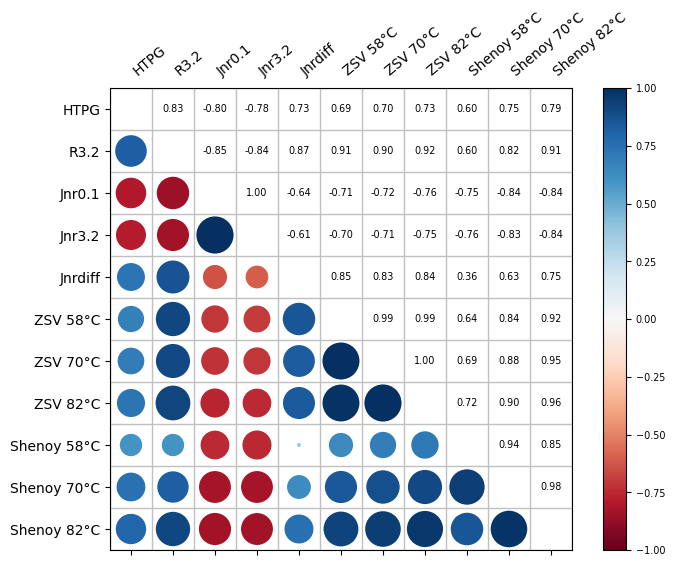

In [7]:
# Define a "df" with only features to be used from "Data" dataframe. 
df = Data[['HTPG', 'R3.2', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff', 'ZSV_58C', 'ZSV_70C', 'ZSV_82C', 'Shenoy_58C', 'Shenoy_70C', 'Shenoy_82C']]
corr = df.corr()
# mask and melt correlation matrix
mask = np.tril(np.ones_like(corr, dtype=bool)) | corr.abs().le(0.1)
melt = corr.mask(mask).melt(ignore_index=False).reset_index()
melt["size"] = melt["value"].abs() * 100
# Generate the figure. 
fig, ax = plt.subplots(figsize=(8, 6))
# normalize colorbar
cmap = plt.cm.RdBu
norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize="x-small")
# plot lower triangle (scatter plot with normalized hue and square markers)
sns.scatterplot(ax=ax, data=melt, x="index", y="variable", size="size", sizes=(20, 800),
                hue="value", hue_norm=norm, palette=cmap,
                style=0, markers=["o"], legend=False)
# format grid
xmin, xmax = (-0.5, corr.shape[0] - 0.5)
ymin, ymax = (-0.5, corr.shape[1] - 0.5)
ax.vlines(np.arange(xmin, xmax + 1), ymin, ymax, lw=1, color="silver")
ax.hlines(np.arange(ymin, ymax + 1), xmin, xmax, lw=1, color="silver")
ax.set(aspect=1, xlim=(xmin, xmax), ylim=(ymax, ymin), xlabel="", ylabel="")
ax.tick_params(labelbottom=False, labeltop=True)
ax.set_xticklabels(['HTPG', 'R3.2', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff', 'ZSV 58°C', 'ZSV 70°C', 'ZSV 82°C', 'Shenoy 58°C', 'Shenoy 70°C', 'Shenoy 82°C'], ha='left', rotation=40)
ax.set_yticklabels(['HTPG', 'R3.2', 'Jnr0.1', 'Jnr3.2', 'Jnrdiff', 'ZSV 58°C', 'ZSV 70°C', 'ZSV 82°C', 'Shenoy 58°C', 'Shenoy 70°C', 'Shenoy 82°C'])
# annotate upper triangle
for y in range(corr.shape[0]):
    for x in range(corr.shape[1]):
        value = corr.mask(mask).to_numpy()[y, x]
        if pd.notna(value):
            plt.text(x, y, f"{value:.2f}", size="x-small",
                     # color=sm.to_rgba(value), weight="bold",
                     ha="center", va="center")

C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_9976\1636774429.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jnr3.2', 'Jnrdiff', 'R3.2', 'HTPG', 'ZSV_58C', 'Shenoy_58C'], ha='left', rotation=40)
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_9976\1636774429.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['Jnr3.2', 'Jnrdiff', 'R3.2', 'HTPG', 'ZSV_58C', 'Shenoy_58C'])


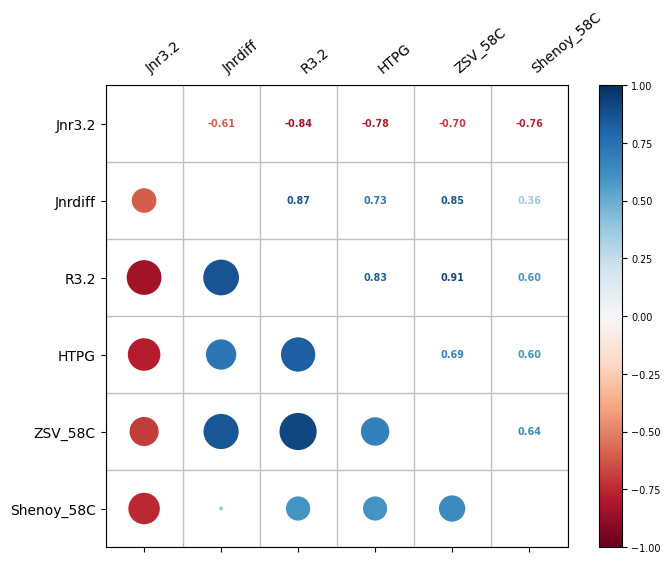

In [8]:
# Define a "df" with only features to be used from "Data" dataframe. 
df = Data[['Jnr3.2', 'Jnrdiff', 'R3.2', 'HTPG', 'ZSV_58C', 'Shenoy_58C']]
corr = df.corr()
# mask and melt correlation matrix
mask = np.tril(np.ones_like(corr, dtype=bool)) | corr.abs().le(0.1)
melt = corr.mask(mask).melt(ignore_index=False).reset_index()
melt["size"] = melt["value"].abs() * 100
# Generate the figure. 
fig, ax = plt.subplots(figsize=(8, 6))
# normalize colorbar
cmap = plt.cm.RdBu
norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize="x-small")
# plot lower triangle (scatter plot with normalized hue and square markers)
sns.scatterplot(ax=ax, data=melt, x="index", y="variable", size="size", sizes=(20, 800),
                hue="value", hue_norm=norm, palette=cmap,
                style=0, markers=["o"], legend=False)
# format grid
xmin, xmax = (-0.5, corr.shape[0] - 0.5)
ymin, ymax = (-0.5, corr.shape[1] - 0.5)
ax.vlines(np.arange(xmin, xmax + 1), ymin, ymax, lw=1, color="silver")
ax.hlines(np.arange(ymin, ymax + 1), xmin, xmax, lw=1, color="silver")
ax.set(aspect=1, xlim=(xmin, xmax), ylim=(ymax, ymin), xlabel="", ylabel="")
ax.tick_params(labelbottom=False, labeltop=True)
ax.set_xticklabels(['Jnr3.2', 'Jnrdiff', 'R3.2', 'HTPG', 'ZSV_58C', 'Shenoy_58C'], ha='left', rotation=40)
ax.set_yticklabels(['Jnr3.2', 'Jnrdiff', 'R3.2', 'HTPG', 'ZSV_58C', 'Shenoy_58C'])
# annotate upper triangle
for y in range(corr.shape[0]):
    for x in range(corr.shape[1]):
        value = corr.mask(mask).to_numpy()[y, x]
        if pd.notna(value):
            plt.text(x, y, f"{value:.2f}", size="x-small",
                     color=sm.to_rgba(value), weight="bold",
                     ha="center", va="center")

__________

## Combine the Results and do Scatter Plots. 

In [9]:
# Combining the results. 
Comb = {'Lane': [], 'Field_Aging': []}
for prop in ['HTPG', 'Jnr3.2', 'R3.2', 'ZSV_58C', 'Shenoy_58C']:
    for metric in ['mean', 'std', 'COV']:
        Comb[f'{prop}_{metric}'] = []
def AddData(DataDict, lbl, arr):
    DataDict[f'{lbl}_mean'].append(arr.mean())
    DataDict[f'{lbl}_std'].append(arr.std())
    DataDict[f'{lbl}_COV'].append(arr.std() / arr.mean())
    return DataDict
for age in Data['Field_Aging'].unique():
    Agedf = Data[Data['Field_Aging'] == age]
    for ln in Agedf['Lane'].unique():
        df = Agedf[Agedf['Lane'] == ln]
        Comb['Lane'].append(ln)
        Comb['Field_Aging'].append(age)
        for prop in ['HTPG', 'Jnr3.2', 'R3.2', 'ZSV_58C', 'Shenoy_58C']:
            Comb = AddData(Comb, prop, df[prop].to_numpy())
Comb = pd.DataFrame(Comb)
Comb

,Lane,Field_Aging,HTPG_mean,HTPG_std,HTPG_COV,Jnr3.2_mean,Jnr3.2_std,Jnr3.2_COV,R3.2_mean,R3.2_std,R3.2_COV,ZSV_58C_mean,ZSV_58C_std,ZSV_58C_COV,Shenoy_58C_mean,Shenoy_58C_std,Shenoy_58C_COV
0,1,0-Month,82.200000,0.571548,0.006953,0.210433,0.001161,0.005519,36.720000,0.008165,0.000222,18973.778544,567.816325,0.029926,71.525735,0.569250,0.007959
1,2,0-Month,80.166667,0.385861,0.004813,0.281100,0.003884,0.013818,34.493333,0.037712,0.001093,17231.944243,1409.260189,0.081782,63.966273,6.899200,0.107857
2,3,0-Month,77.400000,0.432049,0.005582,0.434233,0.008344,0.019215,10.933333,0.028674,0.002623,7473.355320,1263.993168,0.169133,53.121229,8.673483,0.163277
3,4,0-Month,82.333333,0.169967,0.002064,0.149500,0.001143,0.007646,56.726667,0.154128,0.002717,55425.254484,9843.779671,0.177605,76.521865,20.704587,0.270571
4,5,0-Month,76.166667,0.967241,0.012699,0.356133,0.002608,0.007323,13.770000,0.057155,0.004151,9984.471839,1488.884530,0.149120,71.080353,9.988436,0.140523
5,6,0-Month,74.433333,0.188562,0.002533,0.464833,0.003924,0.008441,13.256667,0.084984,0.006411,7297.247409,999.194059,0.136928,51.312542,6.682021,0.130222
6,7,0-Month,76.633333,0.329983,0.004306,0.380467,0.003064,0.008054,16.940000,0.071181,0.004202,9281.799402,3082.726741,0.332126,59.726962,17.647790,0.295474
7,8,0-Month,78.833333,0.169967,0.002156,0.621433,0.002457,0.003953,10.140000,0.035590,0.003510,6764.934583,519.179902,0.076746,47.126342,2.396327,0.050849
8,9,0-Month,75.133333,0.654896,0.008716,0.514300,0.002650,0.005152,12.410000,0.069761,0.005621,7244.726567,995.152989,0.137362,49.859818,6.354504,0.127447
9,10,0-Month,72.466667,0.418994,0.005782,0.757867,0.029977,0.039554,6.553333,0.318991,0.048676,3447.566850,664.233508,0.192667,28.482996,5.259682,0.184660


C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_9976\3582061774.py:2: RuntimeWarning: overflow encountered in exp
  Model = lambda X, a, b, c: a * np.exp(b * X) + c        # Exponential model.
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_9976\3582061774.py:2: RuntimeWarning: overflow encountered in multiply
  Model = lambda X, a, b, c: a * np.exp(b * X) + c        # Exponential model.


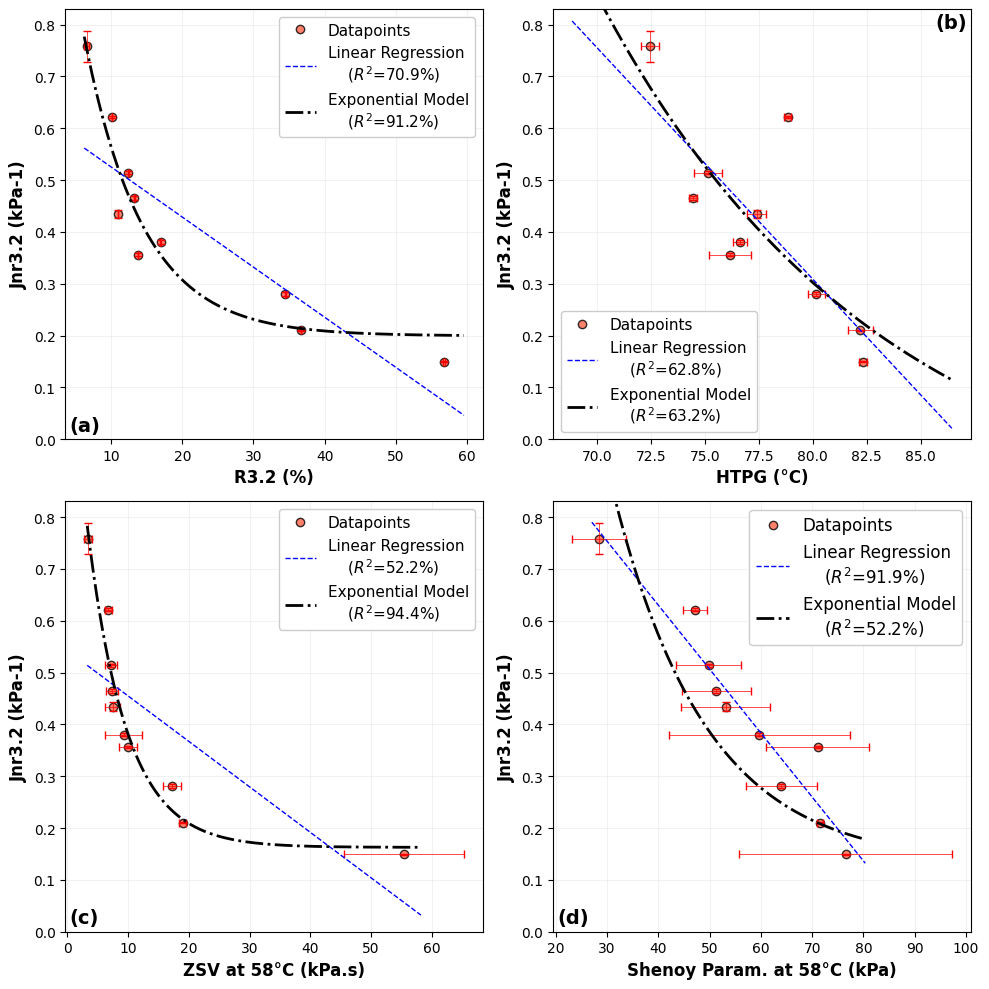

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
Model = lambda X, a, b, c: a * np.exp(b * X) + c        # Exponential model.
# First Jnr3.2 vs R3.2
X  = Comb['R3.2_mean'].to_numpy()
Y  = Comb['Jnr3.2_mean'].to_numpy()
Xs = Comb['R3.2_std'].to_numpy()
Ys = Comb['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[0,0].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[0,0].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[0,0].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
ax[0,0].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[0,0].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[0,0].set_xlabel('R3.2 (%)', fontsize=12, fontweight='bold', color='k')
ax[0,0].set_ylabel('Jnr3.2 (kPa-1)', fontsize=12, fontweight='bold', color='k')
ax[0,0].grid(which='both', color='gray', alpha=0.1)
ax[0,0].set_ylim([0, 0.83])
# ----------------------------------------------------------------------------------------------------------------------
# First Jnr3.2 vs HTPG
X  = Comb['HTPG_mean'].to_numpy()
Y  = Comb['Jnr3.2_mean'].to_numpy()
Xs = Comb['HTPG_std'].to_numpy()
Ys = Comb['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[0,1].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[0,1].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[0,1].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
ax[0,1].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[0,1].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[0,1].set_xlabel('HTPG (°C)', fontsize=12, fontweight='bold', color='k')
ax[0,1].set_ylabel('Jnr3.2 (kPa-1)', fontsize=12, fontweight='bold', color='k')
ax[0,1].grid(which='both', color='gray', alpha=0.1)
ax[0,1].set_ylim([0, 0.83])
# ----------------------------------------------------------------------------------------------------------------------
# First Jnr3.2 vs ZSV
X  = Comb['ZSV_58C_mean'].to_numpy() / 1e3
Y  = Comb['Jnr3.2_mean'].to_numpy()
Xs = Comb['ZSV_58C_std'].to_numpy() / 1e3
Ys = Comb['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[1,0].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[1,0].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[1,0].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
ax[1,0].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[1,0].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[1,0].set_xlabel('ZSV at 58°C (kPa.s)', fontsize=12, fontweight='bold', color='k')
ax[1,0].set_ylabel('Jnr3.2 (kPa-1)', fontsize=12, fontweight='bold', color='k')
ax[1,0].grid(which='both', color='gray', alpha=0.1)
ax[1,0].set_ylim([0, 0.83])
# ----------------------------------------------------------------------------------------------------------------------
# First Jnr3.2 vs Shenoy
X  = Comb['Shenoy_58C_mean'].to_numpy()
Y  = Comb['Jnr3.2_mean'].to_numpy()
Xs = Comb['Shenoy_58C_std'].to_numpy()
Ys = Comb['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
# coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
coeff = [4, -0.055, 0.13]
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[1,1].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[1,1].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[1,1].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
ax[1,1].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[1,1].legend(fontsize=12, framealpha=1.0, fancybox=True)
ax[1,1].set_xlabel('Shenoy Param. at 58°C (kPa)', fontsize=12, fontweight='bold', color='k')
ax[1,1].set_ylabel('Jnr3.2 (kPa-1)', fontsize=12, fontweight='bold', color='k')
ax[1,1].grid(which='both', color='gray', alpha=0.1)
ax[1,1].set_ylim([0, 0.83])
ax[0,0].text(0.01, 0.01, '(a)', fontsize=14, fontweight='bold', color='k', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,1].text(0.99, 0.99, '(b)', fontsize=14, fontweight='bold', color='k', ha='right', va='top', transform=ax[0,1].transAxes)
ax[1,0].text(0.01, 0.01, '(c)', fontsize=14, fontweight='bold', color='k', ha='left', va='bottom', transform=ax[1,0].transAxes)
ax[1,1].text(0.01, 0.01, '(d)', fontsize=14, fontweight='bold', color='k', ha='left', va='bottom', transform=ax[1,1].transAxes)
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Correlation_Rutting_Params.png'), bbox_inches='tight', format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Correlation_Rutting_Params.svg'), bbox_inches='tight', format='svg')

New plot excluding the polymer-modified binders. 

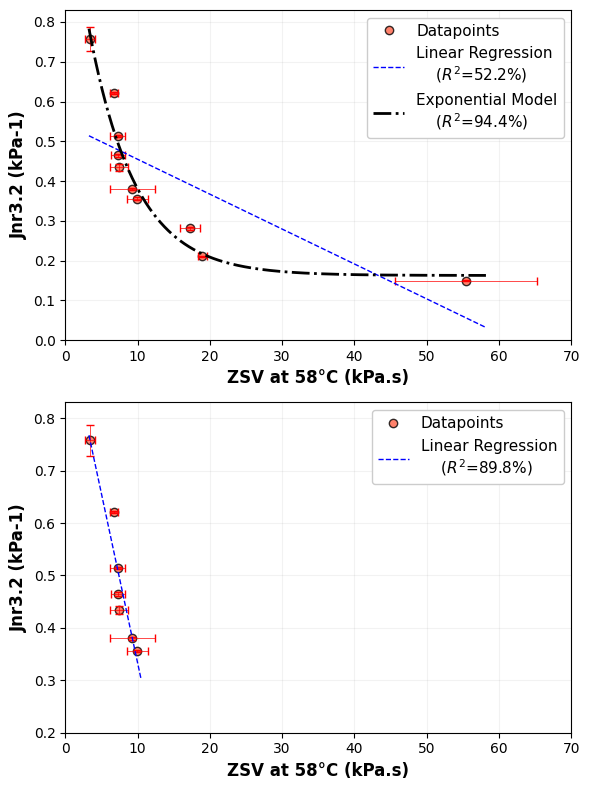

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
Model = lambda X, a, b, c: a * np.exp(b * X) + c        # Exponential model.
# First Jnr3.2 vs ZSV
X  = Comb['ZSV_58C_mean'].to_numpy() / 1e3
Y  = Comb['Jnr3.2_mean'].to_numpy()
Xs = Comb['ZSV_58C_std'].to_numpy() / 1e3
Ys = Comb['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[0].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[0].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[0].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
ax[0].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[0].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[0].set_xlabel('ZSV at 58°C (kPa.s)', fontsize=12, fontweight='bold', color='k')
ax[0].set_ylabel('Jnr3.2 (kPa-1)', fontsize=12, fontweight='bold', color='k')
ax[0].grid(which='both', color='gray', alpha=0.1)
ax[0].set_ylim([0, 0.83])
ax[0].set_xlim([0, 70])
# ----------------------------------------------------------------------------------------------------------------------
# Now, same graph but excluding the Polymer-modified lanes. 
Comb2 = Comb[Comb['Lane'].isin([3, 5, 6, 7, 8, 9, 10])]
X  = Comb2['ZSV_58C_mean'].to_numpy() / 1e3
Y  = Comb2['Jnr3.2_mean'].to_numpy()
Xs = Comb2['ZSV_58C_std'].to_numpy() / 1e3
Ys = Comb2['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[1].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[1].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[1].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
# ax[1].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[1].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[1].set_xlabel('ZSV at 58°C (kPa.s)', fontsize=12, fontweight='bold', color='k')
ax[1].set_ylabel('Jnr3.2 (kPa-1)', fontsize=12, fontweight='bold', color='k')
ax[1].grid(which='both', color='gray', alpha=0.1)
ax[1].set_ylim([0.2, 0.83])
ax[1].set_xlim([0, 70])
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Correlation_ZSV_PolymerModified.png'), bbox_inches='tight', format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Correlation_ZSV_PolymerModified.svg'), bbox_inches='tight', format='svg')

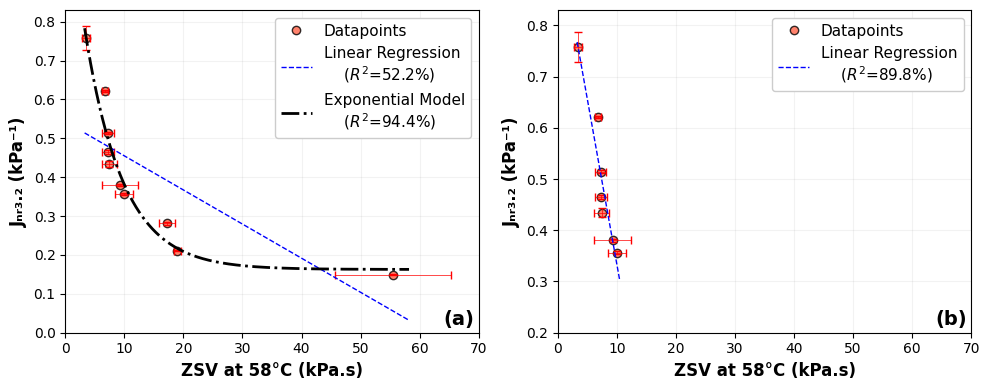

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
Model = lambda X, a, b, c: a * np.exp(b * X) + c        # Exponential model.
# First Jnr3.2 vs ZSV
X  = Comb['ZSV_58C_mean'].to_numpy() / 1e3
Y  = Comb['Jnr3.2_mean'].to_numpy()
Xs = Comb['ZSV_58C_std'].to_numpy() / 1e3
Ys = Comb['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[0].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[0].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[0].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
ax[0].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[0].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[0].set_xlabel('ZSV at 58°C (kPa.s)', fontsize=12, fontweight='bold', color='k')
ax[0].set_ylabel('Jₙᵣ₃.₂ (kPa⁻¹)', fontsize=12, fontweight='bold', color='k')
ax[0].grid(which='both', color='gray', alpha=0.1)
ax[0].set_ylim([0, 0.83])
ax[0].set_xlim([0, 70])
# ----------------------------------------------------------------------------------------------------------------------
# Now, same graph but excluding the Polymer-modified lanes. 
Comb2 = Comb[Comb['Lane'].isin([3, 5, 6, 7, 8, 9, 10])]
X  = Comb2['ZSV_58C_mean'].to_numpy() / 1e3
Y  = Comb2['Jnr3.2_mean'].to_numpy()
Xs = Comb2['ZSV_58C_std'].to_numpy() / 1e3
Ys = Comb2['Jnr3.2_std'].to_numpy()
XX = np.linspace(X.min() * 0.95, X.max() * 1.05, num=10000)
YY = np.polyval(np.polyfit(X, Y, 1), XX)
coeff, _ = curve_fit(Model, X, Y, p0=[1, -0.1, 0])
YY2= Model(XX, coeff[0], coeff[1], coeff[2])
r2 = r2_score(Y, np.polyval(np.polyfit(X, Y, 1), X))
r22= r2_score(Y, Model(X, coeff[0], coeff[1], coeff[2]))
ax[1].plot(X, Y, ls='', marker='o', ms=6, markerfacecolor='tomato', markeredgecolor='k', alpha=0.8, label='Datapoints')
ax[1].errorbar(X, Y, xerr=Xs, yerr=Ys, fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5, ls='')
ax[1].plot(XX, YY, ls='--', lw=1, color='b', label=f'Linear Regression\n    $(R^2$={r2*100:.1f}%)')
# ax[1].plot(XX, YY2, ls='-.', lw=2, color='k', label=f'Exponential Model\n    $(R^2$={r22*100:.1f}%)')
ax[1].legend(fontsize=11, framealpha=1.0, fancybox=True)
ax[1].set_xlabel('ZSV at 58°C (kPa.s)', fontsize=12, fontweight='bold', color='k')
ax[1].set_ylabel('Jₙᵣ₃.₂ (kPa⁻¹)', fontsize=12, fontweight='bold', color='k')
ax[1].grid(which='both', color='gray', alpha=0.1)
ax[1].set_ylim([0.2, 0.83])
ax[1].set_xlim([0, 70])
ax[0].text(0.99, 0.01, '(a)', fontsize=14, fontweight='bold', color='k', transform=ax[0].transAxes, va='bottom', ha='right')
ax[1].text(0.99, 0.01, '(b)', fontsize=14, fontweight='bold', color='k', transform=ax[1].transAxes, va='bottom', ha='right')
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Correlation_ZSV_PolymerModified_Horizontal.png'), bbox_inches='tight', format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Correlation_ZSV_PolymerModified_Horizontal.svg'), bbox_inches='tight', format='svg')